In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.io import read
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np
from sklearn.decomposition import PCA

In [50]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [ ]:
## Set the plotting parameters
seed = 0
identifier = ""
use_AGOX = True

In [ ]:
## Set the descriptors
if use_AGOX:
    from agox.models.descriptors import SOAP
    local_descriptor = SOAP.from_species(["Sc", "S", "Li"], r_cut=5.0)
else:
    from dscribe.descriptors import SOAP as dscribe_SOAP
    avg_local_descriptor = dscribe_SOAP(species=["Sc", "S", "Li"], r_cut=5.0, n_max=8, l_max=6, periodic=True, average="inner")

In [ ]:
## Set the calculators
from chgnet.model import CHGNetCalculator
from ase.calculators.singlepoint import SinglePointCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [ ]:
## Load the unrelaxed structures
unrlxd_structures = read("DTMP"+identifier+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures:
  structure.calc = calc

In [ ]:
## Load the relaxed structures
rlxd_structures = read("DTMP"+identifier+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures:
  structure.calc = calc

In [ ]:
## Read energies from energies_unrlxd_seed0.txt and add to the respective structures using a SinglePointCalculator
## The file has the form "index energy"
## This is done because there seem to be issues with storing the energy in the ASE trajectory file for some setups
filename = "DTMP"+identifier+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures[index].calc = SinglePointCalculator(unrlxd_structures[index], energy=energy * len(unrlxd_structures[index]))


filename = "DTMP"+identifier+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures[index].calc = SinglePointCalculator(rlxd_structures[index], energy=energy * len(rlxd_structures[index]))

In [ ]:
## Get the minimum energy of the relaxed structures
min_energy = np.min([structure.get_potential_energy()/len(structure) for structure in rlxd_structures])

In [ ]:
## Calculate energies per atom for each unrelaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unrlxd_structures]
unrlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Unrelaxed min energy: ", np.min(energies_per_atom))

Unrelaxed min energy:  -6.038233280181885


In [ ]:
## Calculate energies per atom for each relaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in rlxd_structures]
rlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Relaxed min energy: ", np.min(energies_per_atom))

Relaxed min energy:  -6.093416690826416


In [ ]:
## Set up the PCA
pca = PCA(n_components=2)

In [ ]:
## Get the 'super atom' descriptors for the unrelaxed structures
unrlxd_super_atoms = []
for structure in unrlxd_structures:
  unrlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [ ]:
## Get the 'super atom' descriptors for the relaxed structures
rlxd_super_atoms = []
for structure in rlxd_structures:
  rlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [ ]:
## Fit the PCA model to the unrelaxed or relaxed structures
rlxd_string = "rlxd"

In [ ]:
## Save pca model
import pickle
if True:
  if use_AGOX:
    pca.fit(np.squeeze([arr for arr in unrlxd_super_atoms]))
  else:
    pca.fit(np.squeeze([arr for arr in avg_local_descriptor.create(rlxd_structures)]))
  with open("pca_model_all_rlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

## Load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [ ]:
## Transform the unrelaxed and relaxed structures to the reduced space
if use_AGOX:
    unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in unrlxd_super_atoms]))
    rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in rlxd_super_atoms]))
else:
    unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in avg_local_descriptor.create(unrlxd_structures)]))
    rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in avg_local_descriptor.create(rlxd_structures)]))

In [ ]:
## Get the index of the structure with the minimum energy
min_energy_index = np.argmin(rlxd_delta_en_per_atom)
print(min_energy_index)

101


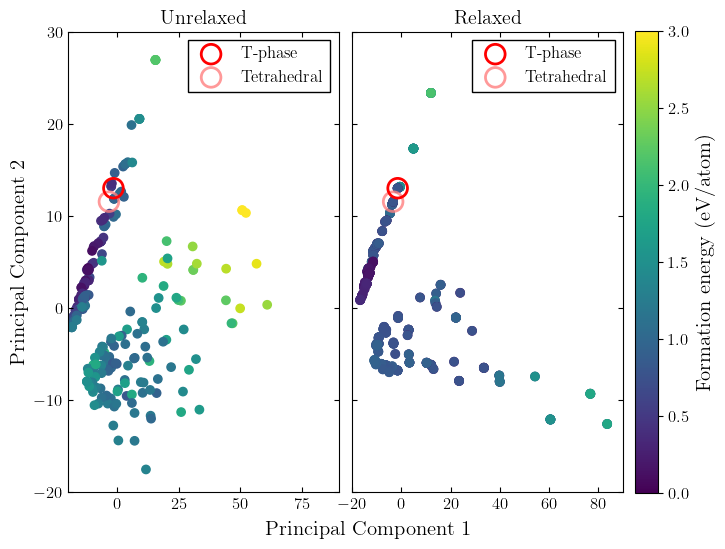

In [ ]:
## Plot the PCA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

## Get the maximum energy for the colourbar
max_en = min(3.0, max(np.max(unrlxd_delta_en_per_atom), np.max(rlxd_delta_en_per_atom)))

## Plot the PCA
axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=unrlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=rlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)

## Add the minimum energy structures to the plot
for ax in axes:
    ax.scatter(rlxd_X_reduced[103, 0], rlxd_X_reduced[103, 1], s=200, edgecolor=[1.0, 0.5, 0.5, 0.8], facecolor='none', linewidth=2, label='Tetrahedral')
    ax.scatter(rlxd_X_reduced[101, 0], rlxd_X_reduced[101, 1], s=200, edgecolor='red', facecolor='none', linewidth=2, label='T-phase')
    ax.legend(fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1.0, edgecolor='black', fancybox=False)

## Add labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center', fontsize=15)
axes[0].set_ylabel('Principal Component 2', fontsize=15)
axes[0].set_title('Unrelaxed')
axes[1].set_title('Relaxed')
if rlxd_string == "rlxd":
  xlims = [-20, 90]
  ylims = [-20, 30]
else:
  xlims = [-20, 90]
  ylims = [-30, 30]

for ax in axes:
  ax.tick_params(axis='both', direction='in')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

## Unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]
axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

## Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

## Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.set_label('Formation energy (eV/atom)', fontsize=15)

## Save the figure
plt.savefig('ScS2-Li_RAFFLE_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')